In [ ]:
#data collection
#RAE
import keras
from keras import backend as K
from keras.utils import Sequence
from keras.models import Sequential, Model
from keras.layers import Input, LSTM, RepeatVector
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.optimizers import SGD, RMSprop, Adam
from keras import objectives
from keras import regularizers
from sklearn.linear_model import Lasso

import numpy as np
import scipy.io
np.set_printoptions(precision = 2, suppress = True)
import os
import nibabel as nib
import pandas as pd
from nibabel import cifti2 as ci
from scipy import stats


path = "/home/qing/Documents/tfMRI_Gambling_preproc/"
dirs = os.listdir(path)

a = np.memmap('sub_Gambling.mymemmap', dtype = 'float32', mode='w+', shape=(253*791,59421))
del a
sub = np.memmap('sub_Gambling.mymemmap', dtype='float32', mode='r+', shape=(253*791,59421))
sub_data = np.memmap('sub_Gambling.mymemmap', dtype='float32', mode='r+', shape=(253*791,59421))

for num1 in range(0,791):
    sub_path =  path + dirs[num1] + "/tfMRI_GAMBLING_LR_Atlas_MSMAll.dtseries.nii"
    print(sub_path)
    print(num1)
    img = nib.load(sub_path)
    img = img.get_data()
    
    img = img[:,0:59421]
    print(np.shape(img))
    if np.shape(img)[0]==253:
        sub[num1*253:(num1+1)*253, ] = img
    else:
        sub[num1*253:(num1+1)*253-4, ] = img
        sub[(num1+1)*253-4:(num1+1)*253, ] = img[245:250]

print(sub)



In [1]:
### zscore y#####
import numpy as np
sub = np.memmap('sub_Gambling.mymemmap', dtype='float32', mode='r+', shape=(253*791,59421))

sub_data = np.memmap('sub_Gambling.mymemmap', dtype='float32', mode='r+', shape=(253*791,59421))
import matplotlib.pyplot as plt
from scipy import stats
from numpy import *
print(np.shape(sub))
img_step = 252 #volumeLength-1
cnt = 0
for num2 in range(0,791*(img_step+1)):
    cnt += 1
    if cnt == (img_step + 1):
        cnt = 0
        sub_data[num2 - img_step: num2 + 1,:] = stats.zscore(sub[num2 - img_step: num2 + 1,:])
        


(200123, 59421)


In [3]:
############## many to many ##########
#RAE
import keras
import numpy as np
from keras import backend as K
from keras.models import Sequential, Model
from tensorflow.contrib.keras import layers
from keras.layers import Input, LSTM, RepeatVector
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.optimizers import SGD, RMSprop, Adam
from keras import objectives
from keras import regularizers
from sklearn.linear_model import Lasso
sub_data = np.memmap('sub_Gambling.mymemmap', dtype='float32', mode='r+', shape=(253*791,59421))
# print(sub_data)
img_step = 252
sub_data1 = sub_data[0:791*(img_step+1),:]
print(np.shape(sub_data1))
data = np.expand_dims(sub_data1, axis=1)
data = np.reshape(data, (791,253 , 59421))
# latent_dim = [320]

input_dim = data.shape[-1] # 13
timesteps =  data.shape[1]# 3

inputs = Input(shape=(timesteps, input_dim,))
layer1 = Dense(128, activation='tanh',activity_regularizer=regularizers.l1(1*10e-7), kernel_regularizer=regularizers.l2(1*10e-4))#, activity_regularizer=regularizers.l1(1*10e-7), kernel_regularizer=regularizers.l2(1*10e-4)
encoded = layer1(inputs)
encoded = LSTM(64,return_sequences=True,activity_regularizer=regularizers.l1(1*10e-7), kernel_regularizer=regularizers.l2(1*10e-4))(encoded)#
encoded = LSTM(32,return_sequences=True,activity_regularizer=regularizers.l1(1*10e-7), kernel_regularizer=regularizers.l2(1*10e-4))(encoded)#, activity_regularizer=regularizers.l1(1*10e-7), kernel_regularizer=regularizers.l2(1*10e-4)

encoder = Model(inputs, encoded)
encoder.summary()

inputs = Input(shape=(timesteps, 32,))
decoded = LSTM(64, return_sequences=True,activation='tanh')(inputs)
decoded = LSTM(128, return_sequences=True,activation='tanh')(decoded)
outputs = Dense(input_dim, activation='tanh')(decoded)


decoder = Model(inputs, outputs)
decoder.summary()
# model for RAE
inputs = Input(shape=(timesteps, input_dim,))
outputs = encoder(inputs)
outputs = decoder(outputs)
sequence_autoencoder = Model(inputs, outputs)

# autoencoder = Model(inputs, decoded)

sequence_autoencoder.compile(optimizer='adam', loss='mse')
sequence_autoencoder.summary()
sequence_autoencoder.fit(data, data, epochs=10, batch_size =1)




(200123, 59421)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 253, 59421)        0         
_________________________________________________________________
dense_1 (Dense)              (None, 253, 128)          7606016   
_________________________________________________________________
lstm_1 (LSTM)                (None, 253, 64)           49408     
_________________________________________________________________
lstm_2 (LSTM)                (None, 253, 32)           12416     
Total params: 7,667,840
Trainable params: 7,667,840
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 253, 32)           0         
__________________________________________________

In [ ]:
#### predict hidden layer ###

y = np.zeros((791,253,32), dtype=float)
for i in range(0,791):
    y[i * 1 : (i + 1) * 1]=encoder.predict(data[i * 1 : (i + 1) * 1])
    
print(y)

In [5]:
### zscore y#####
import matplotlib.pyplot as plt
from scipy import stats
from numpy import *
print(y.shape)
y = np.reshape(y, (791*253, 1, 32))
t = range(0, 253)
plt.plot(t, y[253*0: 253*1, 0,1])
y_norm = np.zeros((253*791, 1,32), dtype=float)
img_step = 252
cnt = 0
for num2 in range(np.shape(y)[0]):
    cnt += 1
    if cnt == (img_step + 1):
        cnt = 0
        y_norm[num2 - img_step: num2 + 1,:] = stats.zscore(y[num2 - img_step : num2 + 1,:])
        

where_are_NaNs = isnan(y_norm)
y_norm[where_are_NaNs] = 0
plt.plot(t, y_norm[253*0: 253*1, 0,1])

(791, 253, 32)


In [43]:
print(np.shape(task_content))

(316, 3)


0.480


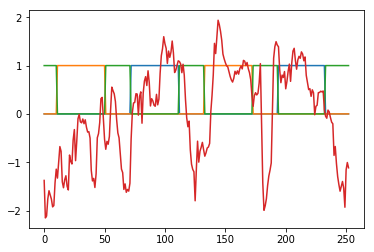

In [74]:
#### plot task_cope and y_norm#####
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
t = range(0, 253)
task = sio.loadmat('/home/qing/Documents/HCP_Label/GAMBLING_label.mat')
task_content = task['Label']

y_ = sio.loadmat('/home/qing/PycharmProjects/RAE/Gambling_y_norm_20190124.mat')
y_norm = y_['y_norm']

plt.plot(t,task_content[:,:])

plt.plot(t, y_norm[253*349:253*350, 0,15])##0##for new, there is three dimension
my_y_ticks = np.arange(-2, 3, 1)
plt.yticks(my_y_ticks)
temp = np.corrcoef(task_content[:,0],y_norm[253*349:253*350,0,15])
print('%.3f' % temp[0,1]) 

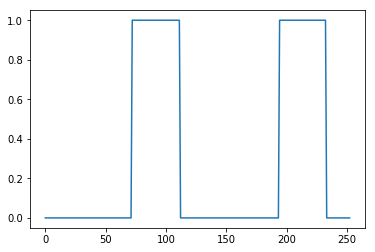

In [303]:
t = range(0, 253)
plt.plot(t,task_content[:,0])

In [392]:
corr_value = np.zeros((32),dtype = float)
for i in range(0, 32):
    a = task_content[:,4]
    b = y_norm[405*4:405*(4+1),0,i]
    temp=np.corrcoef(a,b)
    corr_value[i] = temp[0,1]
print(corr_value)

[-0.01  0.07  0.24 -0.2   0.11  0.06  0.1  -0.25 -0.11 -0.19 -0.21  0.14
 -0.16 -0.19  0.    0.21  0.23 -0.19  0.01 -0.04  0.06  0.21 -0.19  0.15
 -0.02  0.11 -0.15  0.08  0.1   0.13 -0.09 -0.19]


In [7]:
import scipy.io as sio
sio.savemat('Gambling_y_norm_20190207.mat', {'y_norm':y_norm})  
  

In [294]:
#### correlation matrix of networks and volumes ###
import numpy as np
import scipy.io as sio
sub_data = np.memmap('sub_Gambling.mymemmap', dtype='float32', mode='r+', shape=(253*791,59421))

task = sio.loadmat('/home/qing/PycharmProjects/RAE/Gamblingcomponents_img_avg_norm1.mat')
components_img_norm = task['components_img_avg_norm']

corr_net = np.zeros((791, 253, 32), dtype=float)
for i in range(349, 350):
    a = sub_data[i * 253 : (i + 1) * 253, :]
    for k in range(0, 253):
        c = a[k, :]
        for j in range(0, 32):
            b = components_img_norm[j, :]
            temp=np.corrcoef(c,b)
            corr_net[i,k,j] = temp[0,1]#i:subnumber k:timepoint of one sub j:networknumber


In [176]:
print(np.shape(corr_net))
corr_net_norm = np.zeros((791,316,32),dtype = float)
for num2 in range(np.shape(corr_net)[0]):
    corr_net_norm[num2,:] = stats.zscore(corr_net[num2,:])
        


where_are_NaNs= isnan(corr_net_norm)
corr_net_norm[where_are_NaNs] = 0

(791, 316, 32)


In [297]:
print(np.max(corr_net[349,:,:]))

0.24650166247137922


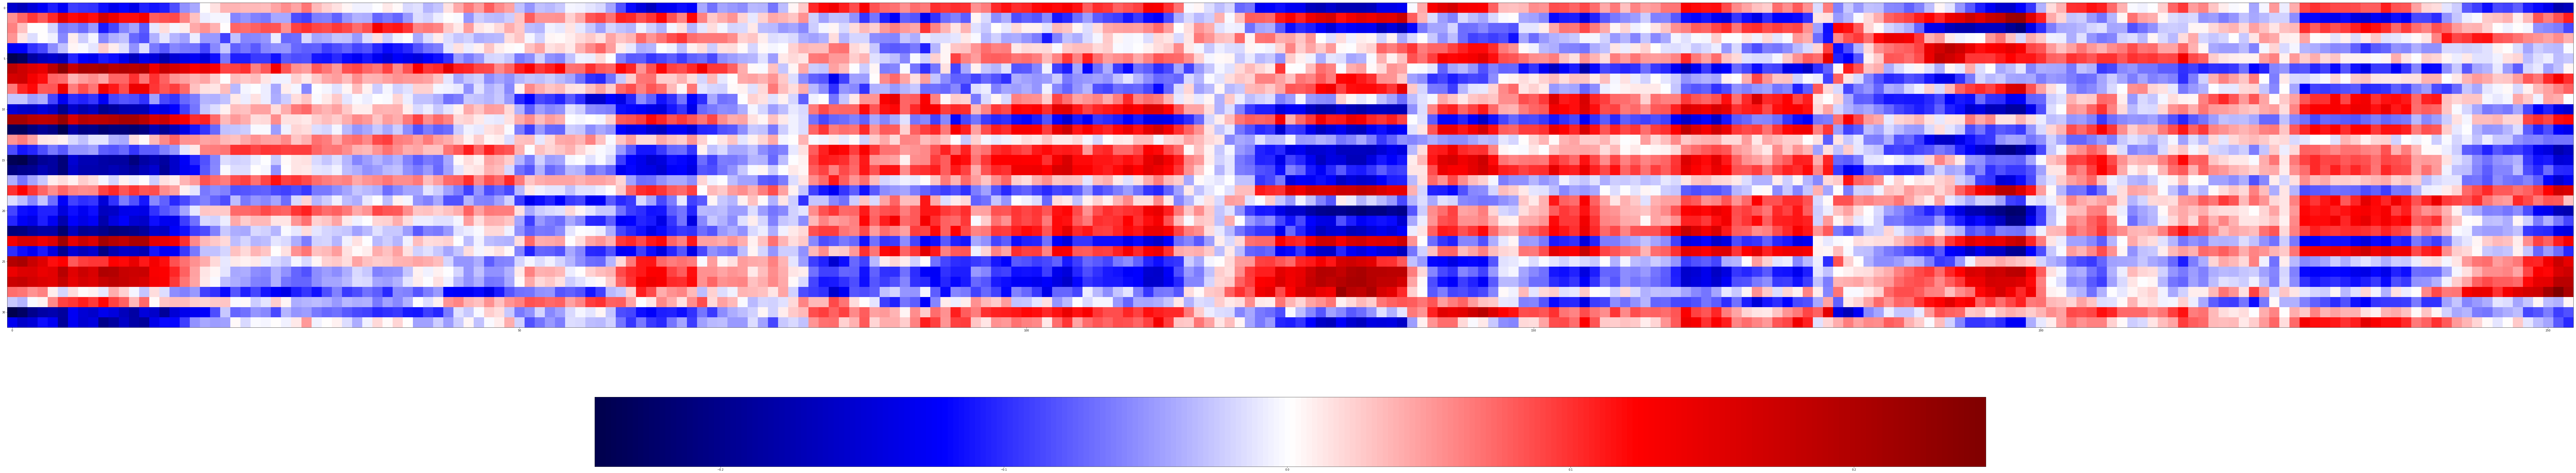

In [296]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(253, 32))
a = np.transpose(corr_net[349,:,:])
im = ax.imshow(a, cmap = 'seismic', interpolation='nearest',origin='upper')
fig.colorbar(im, orientation = 'horizontal')

In [305]:
#calculate the correlation of the GLM with the components
dataFile1 = '/home/qing/PycharmProjects/RAE/Gamblingcomponents_img_avg_norm1.mat'
Gambling1 = sio.loadmat(dataFile1)
Gambling1 = Gambling1['components_img_avg_norm']

dataFile2 = '/home/qing/PycharmProjects/RAE/Gambling_components_img_GLM_norm.mat'
Gambling2 = sio.loadmat(dataFile2)
Gambling2 = Gambling2['components_img_GLM_avg_norm']

corr_map = np.corrcoef(Gambling1[27,:],Gambling2[2,:])
print(corr_map)

[[1.         0.84835213]
 [0.84835213 1.        ]]


In [8]:
##### fit networks by ElasticNet ####

from sklearn.linear_model import ElasticNet
import scipy.io as sio
import numpy as np

# sub_data = np.memmap('sub_Gambling.mymemmap', dtype='float32', mode='r+', shape=(253*791,59421))

y1 = np.squeeze(y_norm)

clf = ElasticNet(alpha=0.7, l1_ratio=0.005)
components_img = np.zeros((791,32, 59421), dtype = float)

for i in range(0,791):
    
    a=y1[i * 253 : (i + 1) * 253, :]
    b=sub_data[i * 253 : (i + 1) * 253, :]
    clf.fit(a, b)
    components_img[i,:,:] = np.transpose(clf.coef_)



In [9]:
components_img_avg = np.zeros((32,59421),dtype = float)
for i in range(0,59421):
    components_img_avg[:,i] = np.mean(components_img[:,:,i],axis = 0)


In [10]:
### zscore y#####
import matplotlib.pyplot as plt
from scipy import stats
from numpy import *
components_img_avg_norm = np.zeros((32,59421),dtype = float)
# print(components_img_GLM.shape)
for num2 in range(0,np.shape(components_img_avg)[0]):
    components_img_avg_norm[num2,:] = stats.zscore(components_img_avg[num2,:])
        


where_are_NaNs= isnan(components_img_avg_norm)
components_img_avg_norm[where_are_NaNs] = 0


In [11]:
import scipy.io as sio
sio.savemat('Gamblingcomponents_img_avg_norm2.mat', {'components_img_avg_norm':components_img_avg_norm})  
  

In [12]:
#### save patterns####
import nibabel as nib
import pandas as pd
from nibabel import cifti2 as ci


image = nib.load('/home/qing/Documents/tfMRI_Emotion_preproc/100307_3T_tfMRI_EMOTION_preproc/tfMRI_EMOTION_LR_Atlas_MSMAll1.dtseries.nii')
header = image.header
print(header)  
print(np.shape(image.get_data()))
#print(image.nifti_header.get_data_shape())
#image.update_headers()

image_to_write = image.get_data()
image_to_write[:, :] = 0
image_to_write[:32, :59421] = components_img_avg_norm

print(np.shape(image_to_write))
#print(image.nifti_header.get_data_shape())
#print(header)
write_img = ci.Cifti2Image(image_to_write, image.header, image.nifti_header)
nib.save(write_img, 'test_Gambling_791sub_LSTM_253back_norm_avg2.dtseries.nii')

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


(176, 91282)
(176, 91282)


In [14]:
from sklearn.linear_model import ElasticNet
import scipy.io as sio
t = range(0, 253)
task = sio.loadmat('/home/qing/Documents/HCP_Label/GAMBLING_label.mat')
task_content = task['Label']

print(np.shape(task_content))

clf_GLM = ElasticNet(alpha=0.7, l1_ratio=0.005)
components_img_GLM = np.zeros((791,3, 59421), dtype = float)

for i in range(0,791):
    
    a=task_content[:,0:3]
    b=sub_data[i * 253 : (i + 1) * 253, :]
    clf_GLM.fit(a, b)
    components_img_GLM[i,:,:] = np.transpose(clf_GLM.coef_)
 

(253, 3)


In [17]:
components_img_GLM_avg = np.zeros((3,59421),dtype = float)
for i in range(0,59421):
    components_img_GLM_avg[:,i] = np.mean(components_img_GLM[:,:,i],axis = 0)
### zscore y#####
import matplotlib.pyplot as plt
from scipy import stats
from numpy import *
components_img_GLM_avg_norm = np.zeros((3,59421),dtype = float)
# print(components_img_GLM.shape)
for num2 in range(0,np.shape(components_img_GLM_avg)[0]):
    components_img_GLM_avg_norm[num2,:] = stats.zscore(components_img_GLM_avg[num2,:])

where_are_NaNs= isnan(components_img_GLM_avg_norm)
components_img_GLM_avg_norm[where_are_NaNs] = 0
import scipy.io as sio
sio.savemat('Gambling_components_img_GLM_norm.mat', {'components_img_GLM_avg_norm':components_img_GLM_avg_norm})  
  

In [65]:
####calculate the correlation of two times trials####

import scipy.io as scio
import numpy as np
dataFile1 = '/home/qing/PycharmProjects/RAE/Gamblingcomponents_img_avg_norm1.mat'
Gambling1 = scio.loadmat(dataFile1)
Gambling1 = Gambling1['components_img_avg_norm']

dataFile2 = '/home/qing/PycharmProjects/RAE/Gamblingcomponents_img_avg_norm2.mat'
Gambling2 = scio.loadmat(dataFile2)
Gambling2 = Gambling2['components_img_avg_norm']

sum_1 = sum(Gambling1[27,:])
sum_2 = sum(Gambling2[28,:])
print(sum_2/sum_1)
corr_network = np.corrcoef(Gambling1[15,:],Gambling2[0:])
print('%.3f' % corr_network[0,1])

14.450064962196008
0.849
